<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/anomalias/src/Anomalias_vizcaina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip3 install windrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
import matplotlib.cm as cm
from functools import reduce
from math import cos, sin, atan, pi
from windrose import WindroseAxes
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'vizcaina'
FILE_DATOS_ESTACION = 'eventos_vizcaina_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres', 'hum_especifica']
LISTA_PWV = []
LISTA_VAR_10M = ['viento']
LISTA_PREC = ['prec']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]
FILES_TRATADOS_10M = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR_10M]
FILES_TRATADOS_PREC = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PREC]

PATH_FINAL_FIGURAS_ANOMALIAS = PATH_DRIVE + PATH_ANOMALIAS + NOMBRE_ESTACION

Cargando datos de Temp, Hum, Pres

In [67]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(df)

In [68]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

Cargando datos de Vapor de Agua

In [69]:
dfList = []
PWV_columns = []
if FILES_PWV:
    
  for f in FILES_PWV:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PWV_columns += [col for col in dfp if col != 'FECHA']


  dfPWV = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPWV = dfPWV.sort_values(by=['FECHA']).reset_index(drop = True)

  dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PWV_columns:
    dfPWV = dfPWV.loc[~dfPWV[var].isnull()].reset_index(drop = True)

  dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPWV = pd.DataFrame(columns = ['FECHA', 'PWV'])

In [70]:
dfPWV

,FECHA,PWV


## Cargando datos de Vientos

$ \theta_p  = arctan(U_p / V_p) $ Direccíon del viento promedio

In [71]:
dfList = []
for f in FILES_TRATADOS_10M:
  dfaux = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(dfaux)

In [72]:
df10m = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)

df10m['FECHA_HORA'] = df10m['FECHA'].apply(lambda x: x[0:13])
df10m['X_VIENTO'] = df10m['VELVIENTO'] * np.sin(np.deg2rad(df10m['DIRECVIENTO'] - 180))
df10m['Y_VIENTO'] = df10m['VELVIENTO'] * np.cos(np.deg2rad(df10m['DIRECVIENTO'] - 180))

dfViento = df10m.copy()

df10m = df10m.groupby('FECHA_HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean' }).reset_index()
df10m['HORA'] = df10m['FECHA_HORA'].apply(lambda x: x[11:13])
df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

## Cargando datos de precipitación

In [73]:
dfList = []
PREC_columns = []
if FILES_TRATADOS_PREC:
    
  for f in FILES_TRATADOS_PREC:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PREC_columns += [col for col in dfp if col != 'FECHA']


  dfPrec = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPrec = dfPrec.sort_values(by=['FECHA']).reset_index(drop = True)

  # dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  # dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PREC_columns:
    dfPrec = dfPrec.loc[~dfPrec[var].isnull()].reset_index(drop = True)

  # dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPrec = pd.DataFrame(columns = ['FECHA'])



In [74]:
dfPrec

,FECHA,PREC
0,2011-01-01 00:10:00-05:00,0.0
1,2011-01-01 00:20:00-05:00,0.0
2,2011-01-01 00:30:00-05:00,0.0
3,2011-01-01 00:40:00-05:00,0.0
4,2011-01-01 00:50:00-05:00,0.0
...,...,...
307957,2017-12-31 23:10:00-05:00,0.0
307958,2017-12-31 23:20:00-05:00,0.0
307959,2017-12-31 23:30:00-05:00,0.0
307960,2017-12-31 23:40:00-05:00,0.0


## Cruzamiento de datos de Temp, hum y pres con PWV

In [75]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION','HUM_ESPECIFICA']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

<ipython-input-75-dc4af6471bed>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)


,HORA,TEMP_mean,HUM_mean,PRESION_mean,HUM_ESPECIFICA_mean
0,00,24.940379,97.271719,1002.528390,19.639330
1,01,24.658066,97.775870,1002.229700,19.402215
2,02,24.389596,98.207073,1002.077061,19.171052
3,03,24.145021,98.539831,1002.064574,18.956639
4,04,23.934742,98.839627,1002.341801,18.766248
5,05,23.738659,99.090145,1002.881911,18.578793
6,06,23.622704,99.273960,1003.515191,18.482250
7,07,24.827433,97.616181,1004.405851,19.584003
8,08,26.731766,88.261660,1004.908196,20.318888
9,09,29.174911,79.913592,1003.285490,20.794495


## Cargando Df de los eventos

In [76]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='date_min_t').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['date_min_t'], format='%Y %m %d %H %M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')  
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'min_t', 'lon_t', 'lat_t']]
dfEventos

,FECHA,FECHA_MIN,min_t,lon_t,lat_t
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058
1,2011-03-09 01:00:00-05:00,2011-03-09 01:20:00-05:00,216.9,-73.693,6.915
2,2011-04-23 20:00:00-05:00,2011-04-23 20:20:00-05:00,196.2,-73.693,6.915
3,2011-04-25 01:00:00-05:00,2011-04-25 01:20:00-05:00,199.6,-73.693,6.772
4,2011-06-07 05:00:00-05:00,2011-06-07 05:20:00-05:00,193.6,-73.693,7.058
5,2011-06-19 04:00:00-05:00,2011-06-19 04:20:00-05:00,205.3,-73.693,7.058
6,2011-07-01 00:00:00-05:00,2011-07-01 00:20:00-05:00,188.4,-73.693,7.058
7,2011-07-19 02:00:00-05:00,2011-07-19 01:40:00-05:00,209.0,-73.693,6.772
8,2011-07-19 02:00:00-05:00,2011-07-19 01:40:00-05:00,209.0,-73.693,6.772
9,2011-08-15 03:00:00-05:00,2011-08-15 02:40:00-05:00,194.3,-73.693,7.058


# Cargando Eventos e encontrando intervalo n horas antes y después

In [77]:
funtime = lambda x, hour : [x + timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)

# ==================================
int_horas = 8
int_minutes = int_horas * 6 * 10
# ==================================
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = -int_horas)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = int_horas)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index()
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:00:00-05:00,-8.0
1,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-7.0
2,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 23:00:00-05:00,-6.0
3,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 00:00:00-05:00,-5.0
4,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 01:00:00-05:00,-4.0
5,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 02:00:00-05:00,-3.0
6,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 03:00:00-05:00,-2.0
7,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 04:00:00-05:00,-1.0
8,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 05:00:00-05:00,0.0
9,0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-13 06:00:00-05:00,1.0


# Cruzamiento con las variables metereológicas. En terminos de 1h


In [78]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean'] 

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [79]:
dfAnomalia

FECHA_POS TEMP_anomalia           HUM_anomalia           PRESION_anomalia  \
                      mean       std         mean       std             mean   
0       -8.0      0.237684  1.354768     0.448061  6.366623        -1.524287   
1       -7.0      0.357784  1.307945    -0.169568  6.618989        -1.407810   
2       -6.0      0.684933  1.305302    -0.338768  6.423845        -1.388499   
3       -5.0      0.545384  1.314691    -0.719591  7.419836        -1.228140   
4       -4.0      0.436687  0.970946    -0.108225  6.204414        -1.514169   
5       -3.0      0.572162  0.872019     0.241455  4.979935        -1.615179   
6       -2.0      0.637224  0.749931    -0.237811  5.062665        -1.061479   
7       -1.0      0.490207  0.724360    -0.254884  3.224819        -1.949233   
8        0.0      0.154805  1.071114     0.149472  2.901302        -1.630833   
9        1.0     -0.257778  1.209719    -0.256477  3.952490        -1.748815   
10       2.0     -0.509879  1.021251     0.113732  3.438423        -1.450860   
11       3.0     -0.682358  1.431416     2.094152  5.968009        -0.452696   
12       4.0     -0.866734  1.953887     3.437925  8.274500         0.295160   
13       5.0     -0.806822  1.535680     4.191425  7.355333         0.007916   
14       6.0     -1.017089  1.529016     4.604236  6.255316        -0.059599   
15       7.0     -1.008481  1.395173     4.049951  5.843949         0.150457   
16       8.0     -1.584866  1.620204     6.944499  5.853342         0.151743   

             HUM_ESPECIFICA_anomalia            
         std                    mean       std  
0   1.328358                0.298751  0.996200  
1   1.550747                0.192475  0.936811  
2   1.523728                0.483198  0.839028  
3   1.660208                0.375324  0.934882  
4   1.540589                0.496795  1.071489  
5   1.572097                0.785131  0.770279  
6   3.414321                0.612457  1.110346  
7   1.466341                0.485858  0.862774  
8   1.911505                0.143794  0.796161  
9   1.865688               -0.377580  1.106233  
10  2.021517               -0.381792  0.970913  
11  3.533626               -0.380907  1.172089  
12  3.687665               -0.299149  1.337290  
13  3.761082               -0.120019  1.247130  
14  2.760951                0.029925  1.147896  
15  2.748378               -0.042470  1.159008  
16  2.481591                0.103082  1.087779

In [80]:
df

,FECHA,TEMP,HUM,PRESION,TEMP_ROCIO,RAZON_MEZCLA,HUM_ESPECIFICA,HORA
0,2011-01-01 01:00:00-05:00,23.7,98.0,NaN,NaN,NaN,NaN,01
1,2011-01-01 02:00:00-05:00,23.1,99.0,NaN,NaN,NaN,NaN,02
2,2011-01-01 03:00:00-05:00,22.8,100.0,NaN,NaN,NaN,NaN,03
3,2011-01-01 04:00:00-05:00,22.4,100.0,NaN,NaN,NaN,NaN,04
4,2011-01-01 05:00:00-05:00,22.1,100.0,NaN,NaN,NaN,NaN,05
...,...,...,...,...,...,...,...,...
51396,2017-12-31 19:00:00-05:00,25.9,93.0,998.7,297.856715,0.020203,19.802549,19
51397,2017-12-31 20:00:00-05:00,25.1,97.0,999.6,297.750675,0.020052,19.658219,20
51398,2017-12-31 21:00:00-05:00,24.7,99.0,1000.3,297.685499,0.019958,19.567088,21
51399,2017-12-31 22:00:00-05:00,24.7,99.0,1001.1,297.685499,0.019941,19.551266,22


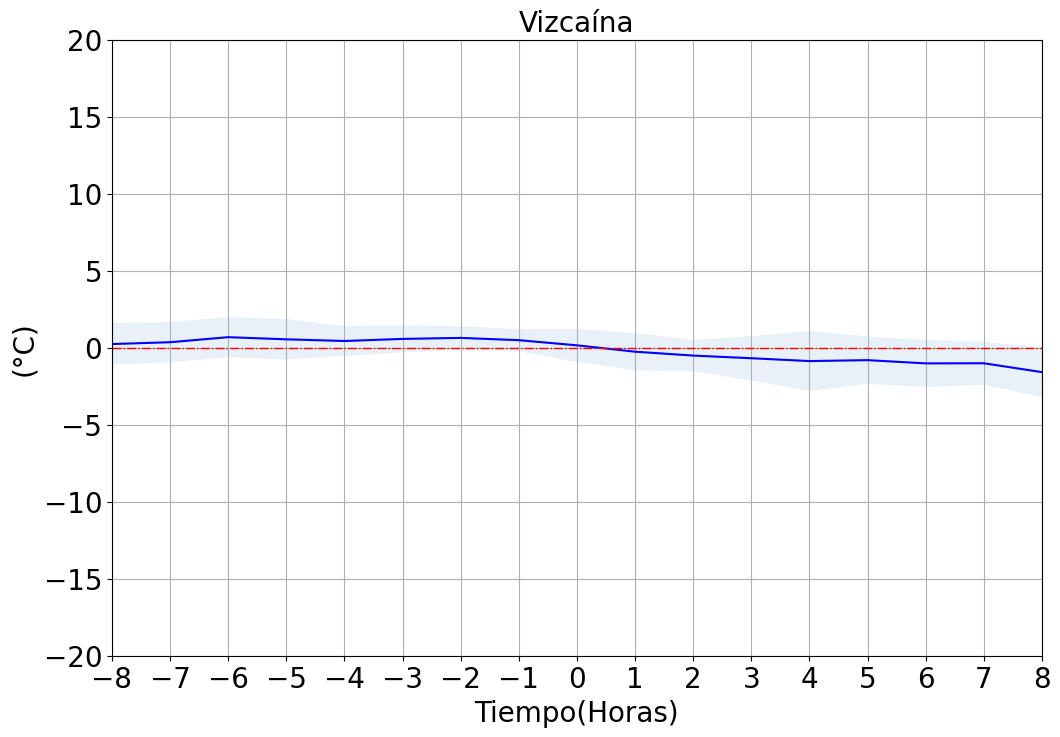

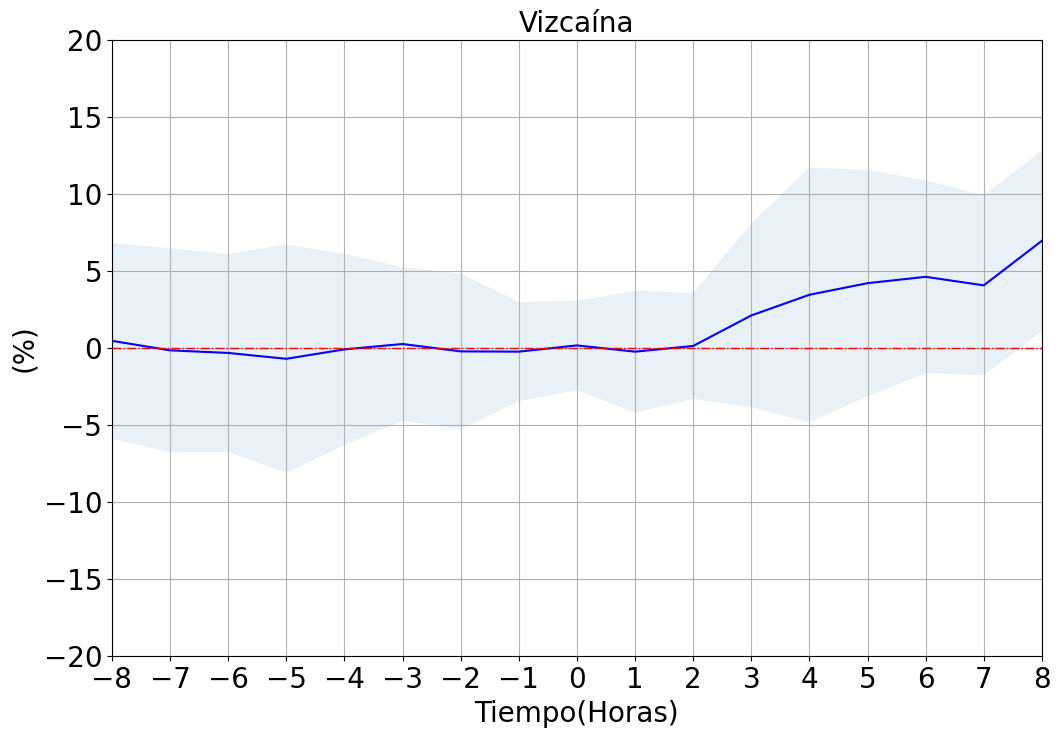

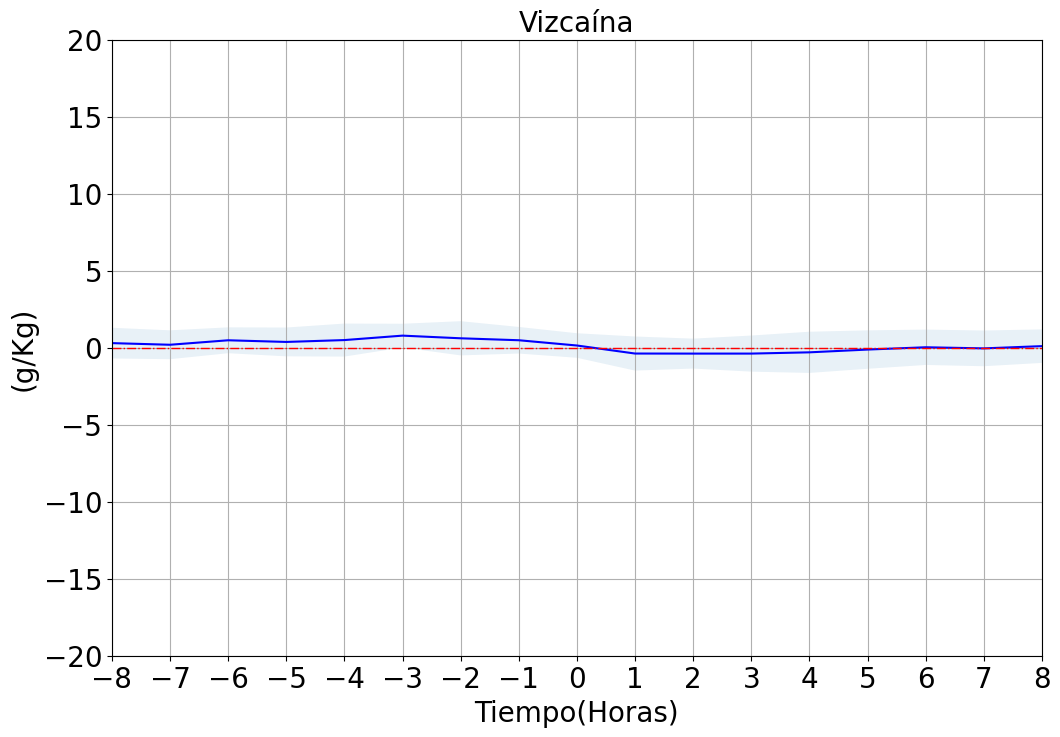

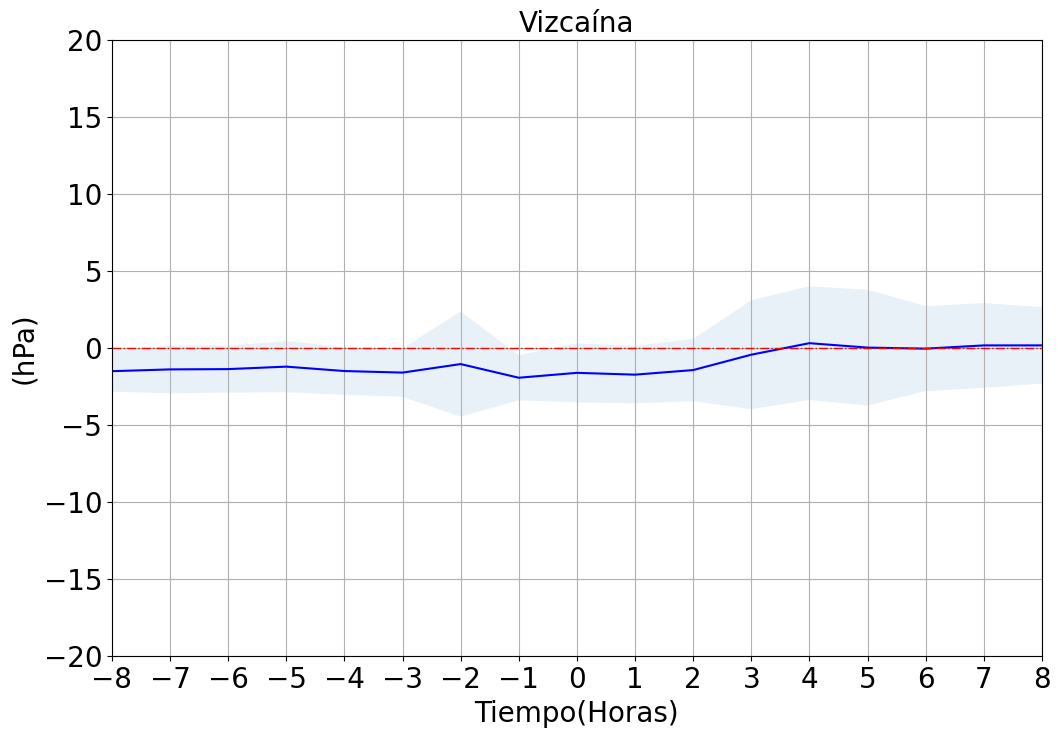

In [81]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])
  plt.ylim(-20,20)
  #if ylimit:
    #plt.ylim(*ylimit)
  plt.xlabel("Tiempo(Horas)", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)'},
              'HUM_ESPECIFICA_anomalia' : {'title' : 'Anomalias de Humedad Específica', 'name2save' : f'anomalias_humedad_especifica_20h_7h_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(g/Kg)', 'ylimit': [-5, 5]},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)'},
              # 'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# dfAnomalia

# **Gráfico de caja y bigote para anomalias** 

In [82]:
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.cbook import _reshape_2D

# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[25, 75]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.percentile(x, 50)
        ## Altered line
        q1, q3 = np.percentile(x, (percents[0], percents[1]))

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.isscalar(whis):
            if np.isreal(whis):
                loval = q1 - whis * stats['iqr']
                hival = q3 + whis * stats['iqr']
            elif whis in ['range', 'limit', 'limits', 'min/max']:
                loval = np.min(x)
                hival = np.max(x)
            else:
                raise ValueError('whis must be a float, valid string, or list '
                                 'of percentiles')
        else:
            loval = np.percentile(x, whis[0])
            hival = np.percentile(x, whis[1])

        # get high extreme
        wiskhi = np.compress(x <= hival, x)
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
        else:
            stats['whishi'] = np.max(wiskhi)

        # get low extreme
        wisklo = np.compress(x >= loval, x)
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
        else:
            stats['whislo'] = np.min(wisklo)

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

def plot_caja_bigote(
    df, ## Dataframe usado para calcular las metricas de cuartiles
    columna_x, ## Nombre de la columna para agrupar
    columna_y, ## Nombre de la columna con la variable
    titulo, ## Titulo de la figura
    rotulo_x, ## Nombre que aparece en el rotulo para el eje X
    rotulo_y, ## Nombre que aparece en el rotulo para el eje Y
    nombre_estacion, ## Nombre de la estación
    nombre_figura, ## Nombre usado para guardar la figura
    path_para_salvar, ## Path para salvar la figura
    lista_xtick=[], ## Colocar para substituir los nombres en el eje X
    ylim=[], ## Colocar para cambiar el rango del gráfico en el eje Y
    cero_vertical=False ## Colocar como True si quiere que aparezca la linea vertical para el dato 0
    ):
  
  stats = {}

  # Compute the boxplot stats (as in the default matplotlib implementation)
  variable_label = df[columna_x].unique()
  variable_label = np.sort(variable_label)
  for var_filter in variable_label:
    df_plot = df[df[columna_y].notnull()]
    df_plot = df_plot[df_plot[columna_x] == var_filter][columna_y].to_numpy()
    stats[var_filter] = my_boxplot_stats(df_plot, percents=[25, 75])[0]
  fig, ax = plt.subplots(1, 1)
  fig.set_size_inches(12,8)
  ax.plot(np.zeros_like(variable_label), color = 'r', linestyle = '-.', linewidth = 1)
  ax.bxp([stats[numb] for numb in stats.keys()], positions=range(len(variable_label)))
  ax.grid()
  ax.set_xlabel(rotulo_x, fontsize=20)
  ax.set_ylabel(rotulo_y, fontsize=20)
  ax.xaxis.set_tick_params(labelsize=20)
  ax.yaxis.set_tick_params(labelsize=20)
  if ylim:
    ax.set_ylim(ylim)
  ax.set_title(nombre_estacion.capitalize(), fontsize= 20)
  if lista_xtick:
    ax.set_xticks(range(0, len(lista_xtick), 1), labels = lista_xtick, fontsize= 20)
    if cero_vertical:
      ax.axvline(x=int(len(lista_xtick)/2), color = 'r')
  fig.savefig(path_para_salvar + nombre_estacion.capitalize() + "_" + nombre_figura, format='png', bbox_inches = 'tight' )

In [83]:
label_x_values = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

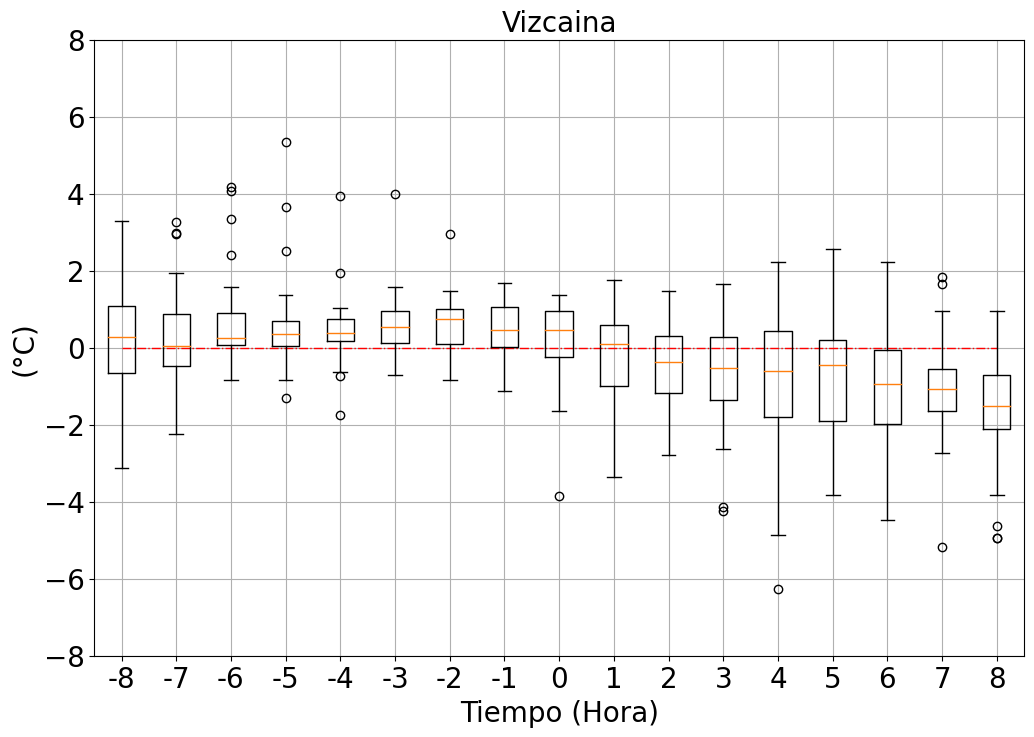

In [84]:

plot_caja_bigote(
    df=dfCross,
    columna_x="FECHA_POS",
    columna_y="TEMP_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Hora)",
    rotulo_y="(°C)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_temp_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values,
    ylim=[-8, 8]
)

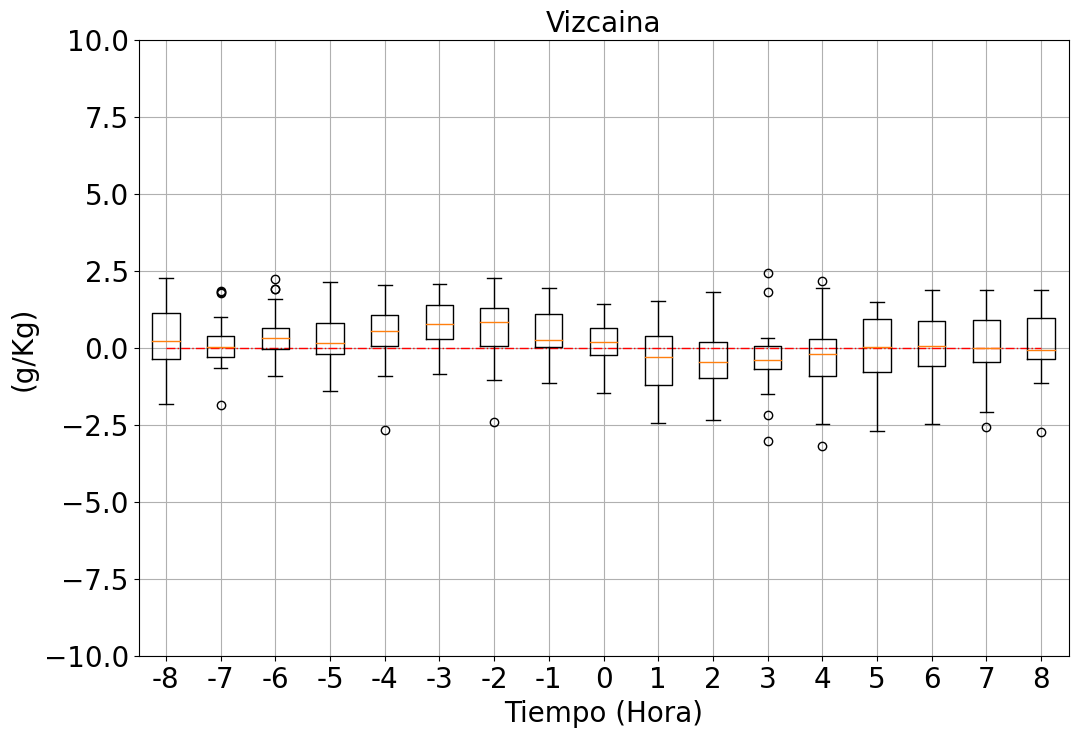

In [85]:
plot_caja_bigote(
    df=dfCross,
    columna_x="FECHA_POS",
    columna_y="HUM_ESPECIFICA_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Hora)",
    rotulo_y="(g/Kg)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_hum_especifica_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values,
    ylim=[-10, 10]
)

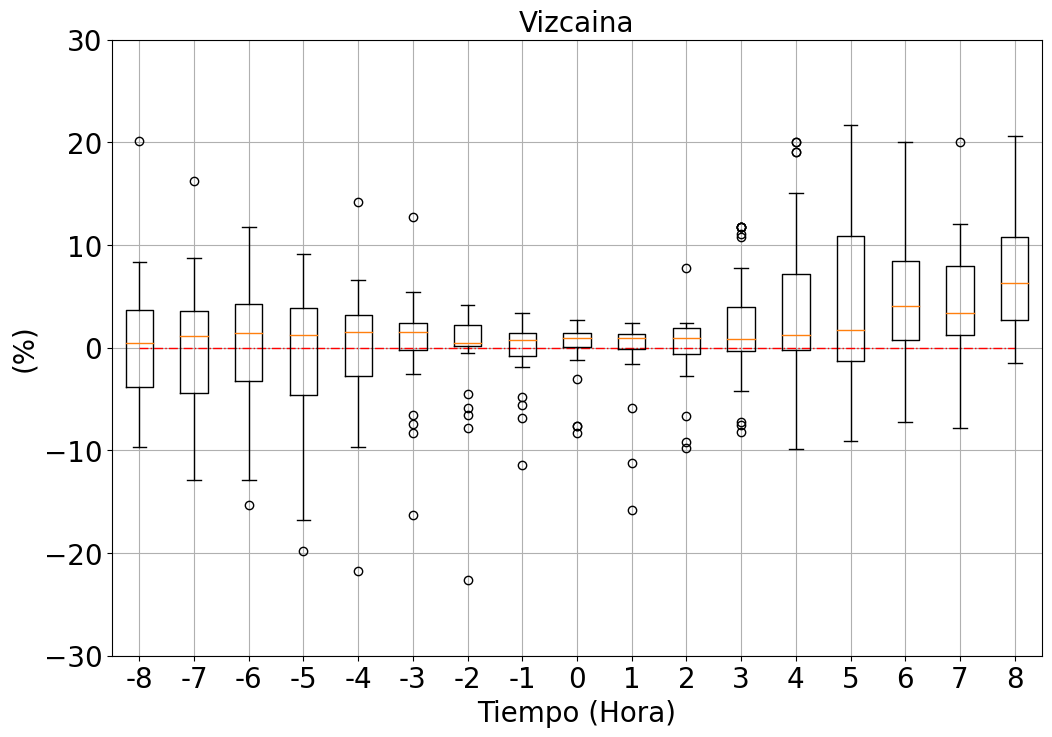

In [86]:
plot_caja_bigote(
    df=dfCross,
    columna_x="FECHA_POS",
    columna_y="HUM_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Hora)",
    rotulo_y="(%)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_HUM_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values,
    ylim=[-30, 30]
)
  

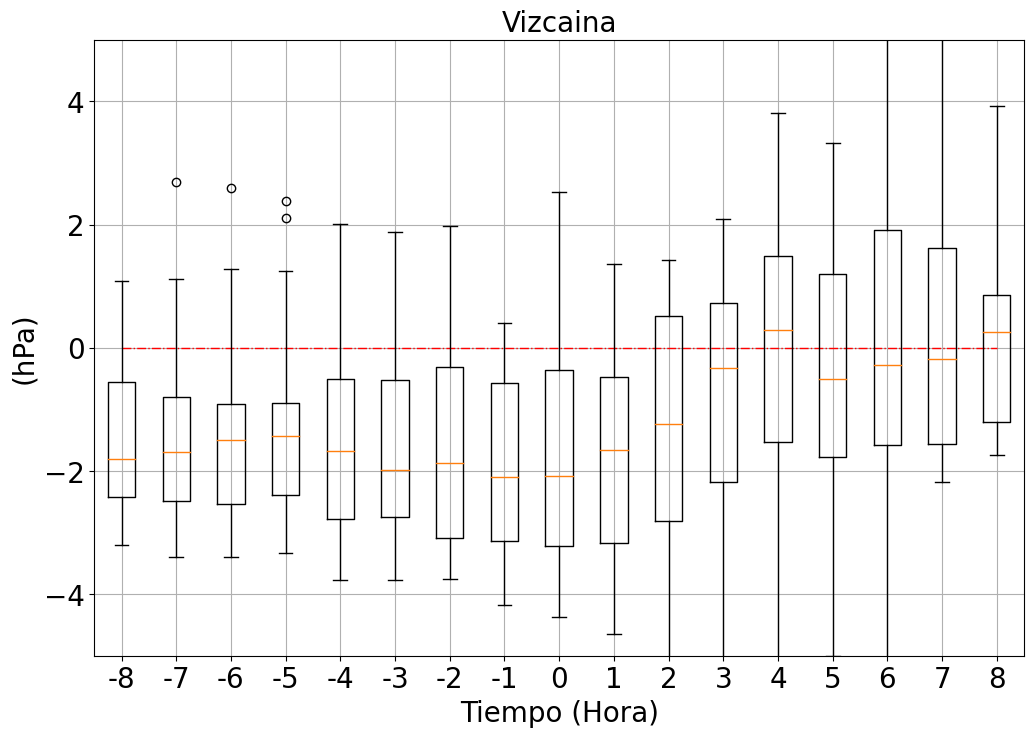

In [87]:
plot_caja_bigote(
    df=dfCross,
    columna_x="FECHA_POS",
    columna_y="PRESION_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Hora)",
    rotulo_y="(hPa)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_PRESION_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values,
    ylim=[-5, 5]
)
  

# Análisis con los 21 Eventos que tienen todas las variábles metereológicas completas

In [88]:
dfEventos0 = dfCross.loc[dfCross['FECHA_POS'] == 0.]
dfEventos0 = dfEventos0[['FECHA_EVENTO', 'min_t', 'index'] + columns_mean]
dfEventos0['NUMERO_VARS'] = dfEventos0[columns_mean].notnull().sum(axis=1)
dfEventos0

,FECHA_EVENTO,min_t,index,TEMP,HUM,PRESION,HUM_ESPECIFICA,NUMERO_VARS
8,2011-02-13 05:00:00-05:00,204.5,0,24.2,96.0,NaN,NaN,2
25,2011-03-09 01:00:00-05:00,216.9,1,24.9,99.0,NaN,NaN,2
42,2011-04-23 20:00:00-05:00,196.2,2,NaN,NaN,NaN,NaN,0
59,2011-04-25 01:00:00-05:00,199.6,3,NaN,NaN,NaN,NaN,0
76,2011-06-07 05:00:00-05:00,193.6,4,24.9,100.0,NaN,NaN,2
93,2011-06-19 04:00:00-05:00,205.3,5,25.0,99.0,NaN,NaN,2
110,2011-07-01 00:00:00-05:00,188.4,6,21.1,100.0,NaN,NaN,2
127,2011-07-19 02:00:00-05:00,209.0,7,25.5,100.0,NaN,NaN,2
144,2011-07-19 02:00:00-05:00,209.0,8,25.5,100.0,NaN,NaN,2
161,2011-08-15 03:00:00-05:00,194.3,9,22.6,99.0,NaN,NaN,2


In [89]:
dfEventos0.count()

FECHA_EVENTO      39
min_t             39
index             39
TEMP              31
HUM               31
PRESION           20
HUM_ESPECIFICA    20
NUMERO_VARS       39
dtype: int64

In [90]:
dfEventos0['NUMERO_VARS'].value_counts()

4    20
2    11
0     8
Name: NUMERO_VARS, dtype: int64

In [91]:
dfVarsCompletas = dfEventos0.loc[dfEventos0['NUMERO_VARS'] == 3]
indexVarsCompletas = dfVarsCompletas['index']
dfVarsComp = pd.merge(dfCross, indexVarsCompletas, on = 'index', how = 'inner')

dfAnomaliaVarsComp = dfVarsComp[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()
dfAnomaliaVarsComp

Empty DataFrame
Columns: [(FECHA_POS, ), (TEMP_anomalia, mean), (TEMP_anomalia, std), (HUM_anomalia, mean), (HUM_anomalia, std), (PRESION_anomalia, mean), (PRESION_anomalia, std), (HUM_ESPECIFICA_anomalia, mean), (HUM_ESPECIFICA_anomalia, std)]
Index: []

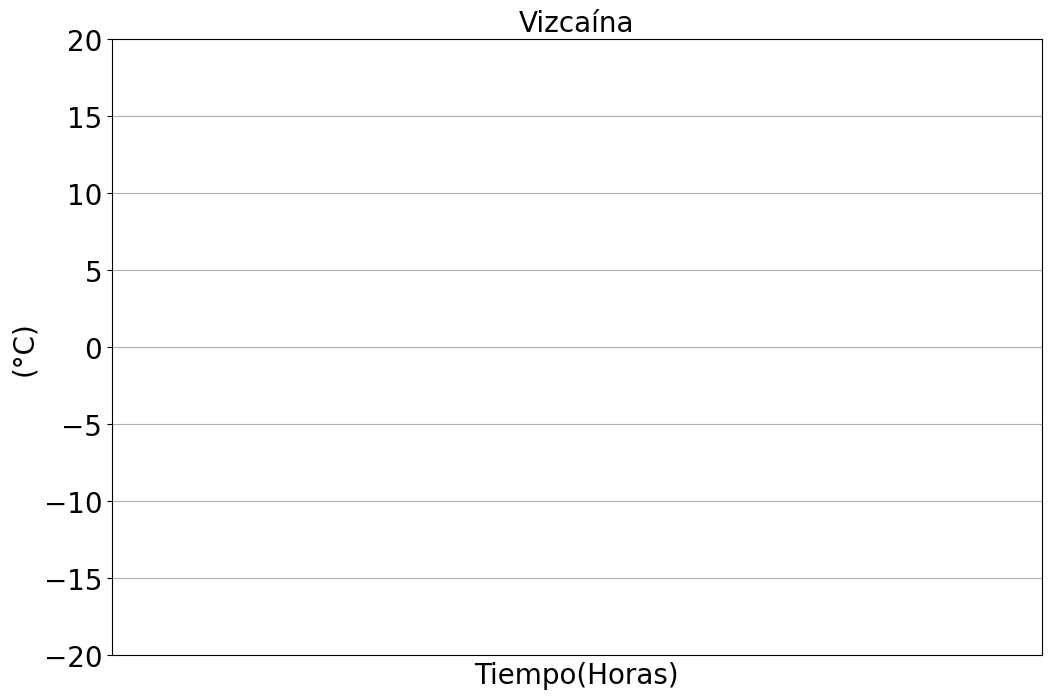

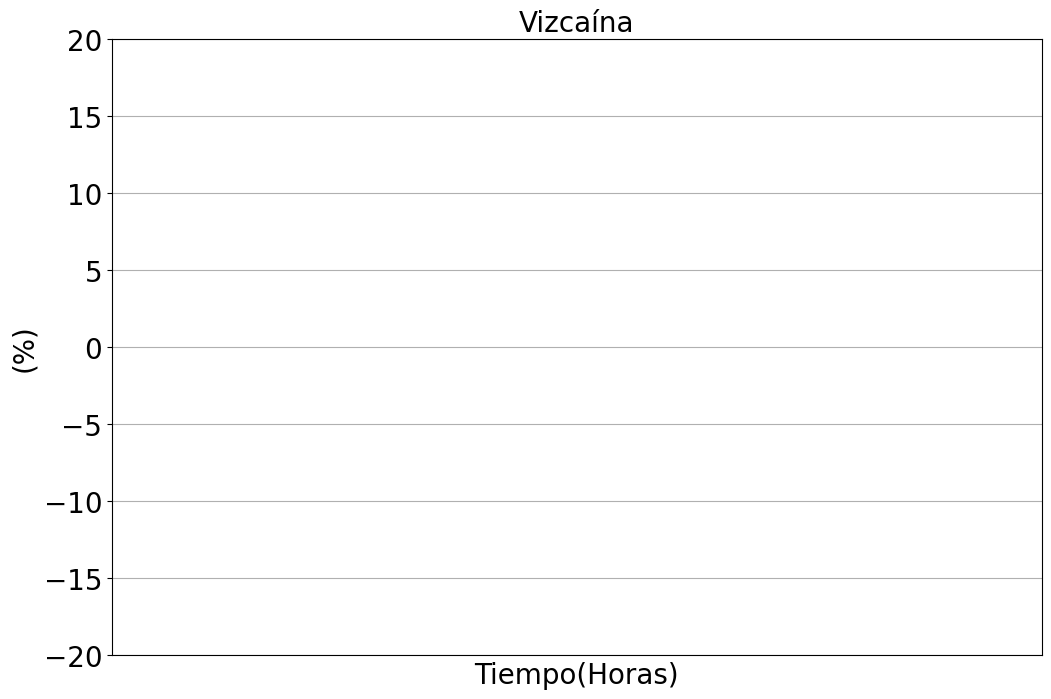

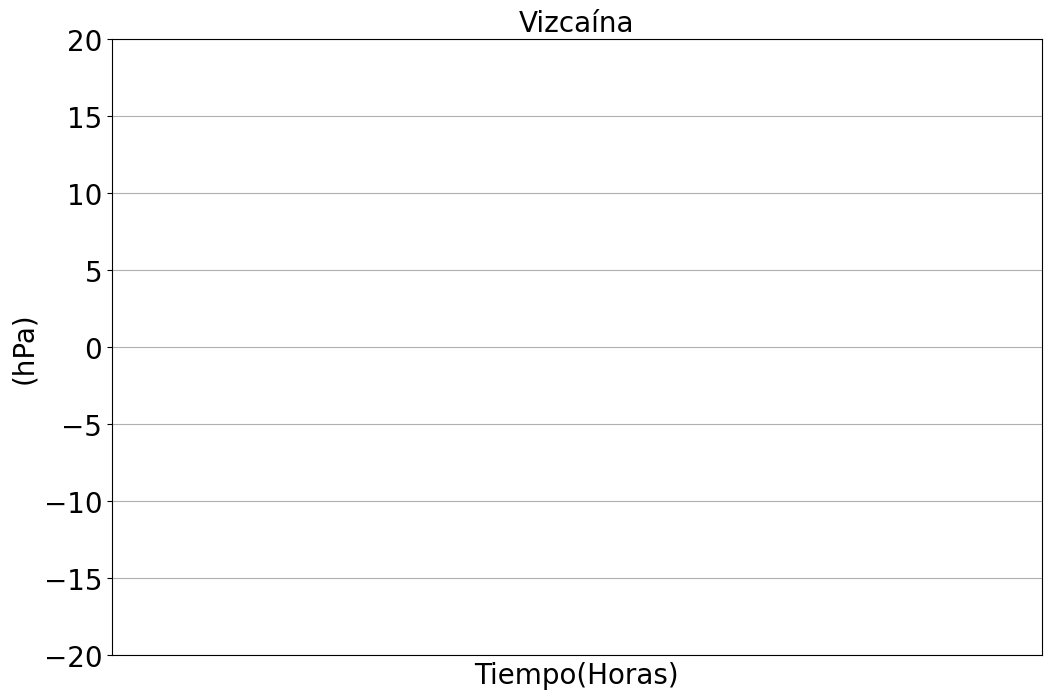

In [92]:
dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)'},
              # 'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : 'Vapor de agua (mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomaliaVarsComp, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# Análisis para Dirección del Viento 

In [93]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

# df10mean['DIRVIENTO_mean'] = df10mean.apply(func_dir, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
# df10mean['VELVIENTO_mean'] = df10mean.apply(func_vel, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10m['DIRVIENTO'] = df10m.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
df10m['VELVIENTO'] = df10m.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

In [94]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA,DIRVIENTO,VELVIENTO
0,2011-01-02 00,-0.063847,-0.596293,00,2011-01-02 00:00:00-05:00,186.111533,0.599702
1,2011-01-02 01,-0.076218,-0.559301,01,2011-01-02 01:00:00-05:00,187.760136,0.564470
2,2011-01-02 02,-0.034522,-0.431268,02,2011-01-02 02:00:00-05:00,184.576598,0.432647
3,2011-01-02 03,-0.077836,-0.493173,03,2011-01-02 03:00:00-05:00,188.968875,0.499277
4,2011-01-02 04,-0.127415,-0.483384,04,2011-01-02 04:00:00-05:00,194.766700,0.499895
...,...,...,...,...,...,...,...
24116,2017-12-31 19,-0.258113,0.324864,19,2017-12-31 19:00:00-05:00,321.531924,0.414921
24117,2017-12-31 20,0.026130,0.282996,20,2017-12-31 20:00:00-05:00,5.275413,0.284200
24118,2017-12-31 21,0.014230,0.216092,21,2017-12-31 21:00:00-05:00,3.767688,0.216560
24119,2017-12-31 22,0.487289,0.111343,22,2017-12-31 22:00:00-05:00,77.129189,0.499848


# Cargando Eventos e encontrando intervalo m minutos antes y después

In [95]:
funtimeMinutes = lambda x, minute : [x + timedelta(minutes = h) for h in (range(0, minute+1, 10) if minute > 0 else range(minute, 0, 10))]

dfEventAnMin = dfEventos.copy()

dfEventAnMin['FECHA_ANTES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = -int_minutes)
dfEventAnMin['FECHA_DESPUES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = int_minutes)

dfEventAnMin['FECHA_INTERVALO'] = dfEventAnMin['FECHA_ANTES_MIN'] + dfEventAnMin['FECHA_DESPUES_MIN']
dfEventAnMin = dfEventAnMin.drop(columns=['FECHA_ANTES_MIN', 'FECHA_DESPUES_MIN']).explode('FECHA_INTERVALO')
dfEventAnMin['FECHA_POS'] = (dfEventAnMin['FECHA_INTERVALO'] - dfEventAnMin['FECHA_MIN'])/ pd.Timedelta(minutes=1)
dfEventAnMin = dfEventAnMin.rename(columns={'FECHA_MIN' : 'FECHA_EVENTO', 'FECHA': 'FECHA_HORA', 'FECHA_INTERVALO': 'FECHA'}).reset_index(drop=True)
dfEventAnMin['FECHA'] = dfEventAnMin['FECHA'].astype(str)

dfEventAnMin.head(10)

,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:20:00-05:00,-480.0
1,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:30:00-05:00,-470.0
2,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:40:00-05:00,-460.0
3,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:50:00-05:00,-450.0
4,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-440.0
5,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:10:00-05:00,-430.0
6,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:20:00-05:00,-420.0
7,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:30:00-05:00,-410.0
8,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:40:00-05:00,-400.0
9,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:50:00-05:00,-390.0


In [96]:
dfCrossPrec = pd.merge(dfEventAnMin, dfPrec, on='FECHA', how = 'left')

dfCrossPrecGroup = dfCrossPrec.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})
dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossPrecGroup

FECHA_POS      PREC          
                  mean       std
0     -480.0  0.000000  0.000000
1     -470.0  0.000000  0.000000
2     -460.0  0.003704  0.019245
3     -450.0  0.000000  0.000000
4     -440.0  0.000000  0.000000
..       ...       ...       ...
92     440.0  0.040000  0.201032
93     450.0  0.026667  0.111211
94     460.0  0.042857  0.226779
95     470.0  0.058621  0.315682
96     480.0  0.103448  0.538173

[97 rows x 3 columns]

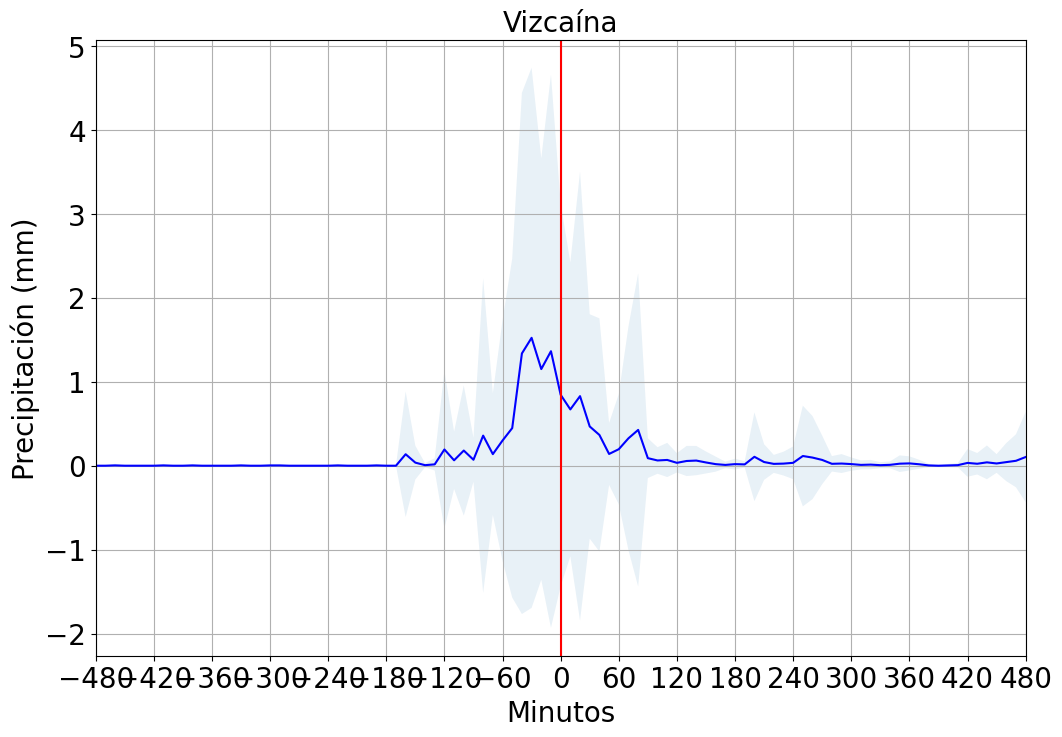

In [97]:
def plot_10m_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'PREC' : {'title' : 'Análisis de Precipitación de eventos convectivos', 'name2save' : f'analisis_prec_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Precipitación (mm)'},

    }

for key in dict_names.keys():
  plot_10m_interval(dfCrossPrecGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes)


In [98]:
label_x_values_prec = [str(x) if x%120 == 0 else "" for x in list(range(-480, 481, 10))]

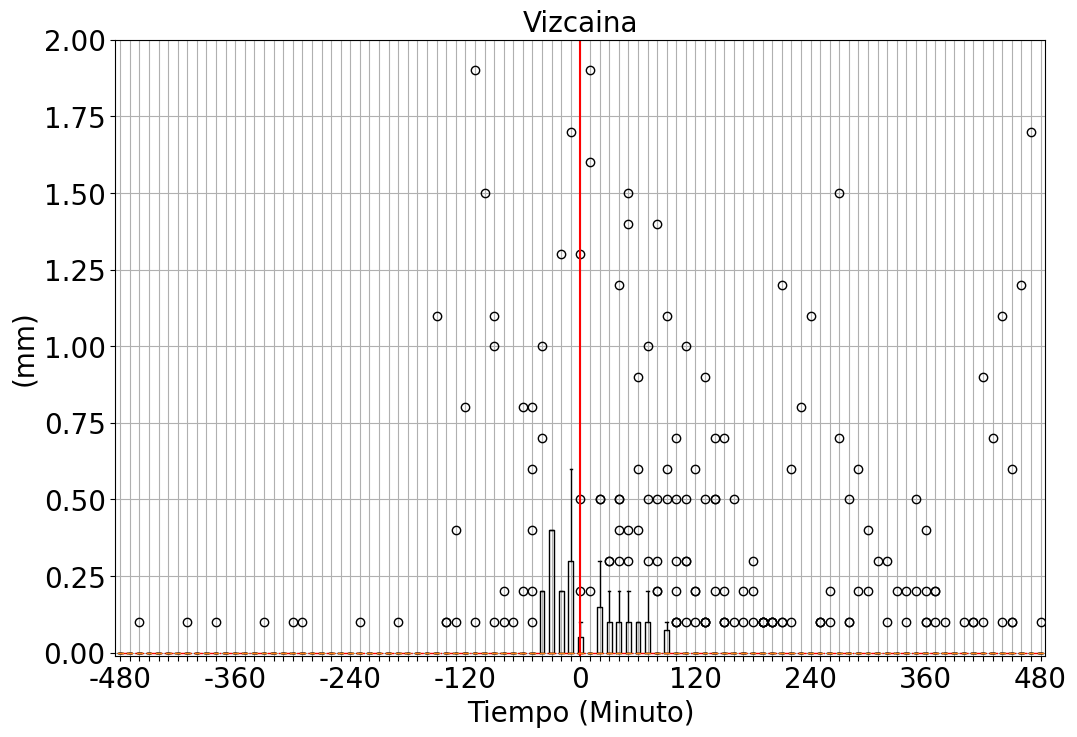

In [99]:

plot_caja_bigote(
    df=dfCrossPrec,
    columna_x="FECHA_POS",
    columna_y="PREC",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Minuto)",
    rotulo_y="(mm)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_PREC_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values_prec,
    ylim=[-0.01, 2],
    cero_vertical=True
)

# Análisis de percentiles - Precipitación

In [100]:
def plot_percentil_interval_prec(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency],fontsize=20)
  plt.yticks(fontsize=20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  #plt.plot(df['FECHA_POS'], df[.5], label = f"Percentil")
  ## Gráfica del promedio 
  plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], linestyle = '--')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  
  plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  plt.ylim(0,5)
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize=20)
  plt.ylabel(ylabel_name, fontsize=20)
  plt.title("Vizcaína", fontsize=20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


<ipython-input-101-695071baccc5>:7: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfPercentilPrec = dfPercentilPrec.join(dfAggPrec, "FECHA_POS")


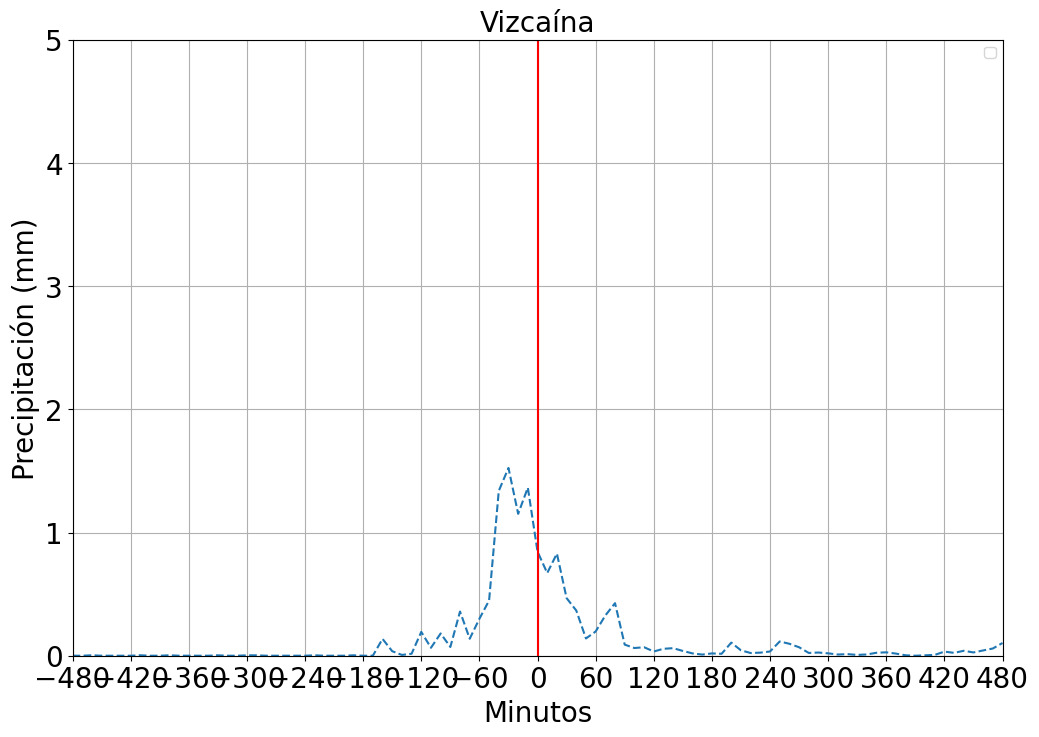

In [101]:
list_percentil = [ 0.05, .1, .20, .25, .50, .75, .80, .90, 0.95]
dfCrossPrecNotNan = dfCrossPrec.dropna().reset_index()
dfPercentilPrec= dfCrossPrecNotNan.groupby("FECHA_POS")['PREC'].quantile(list_percentil).reset_index()
dfAggPrec = dfCrossPrecNotNan.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})

dfPercentilPrec = dfPercentilPrec.pivot(index='FECHA_POS', columns='level_1')['PREC'].reset_index()
dfPercentilPrec = dfPercentilPrec.join(dfAggPrec, "FECHA_POS")

dict_names = {'title' : 'Análisis de precipitación', 
              'name2save' : f'analisis_precipitacion_percentil_{NOMBRE_ESTACION}_{int_minutes}m.png', 
              'ylabel' : 'Precipitación (mm)'
              }

plot_percentil_interval_prec(dfPercentilPrec, [.10, .10], 'PREC', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

# Análisis de Viento

In [110]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

In [111]:
dfEventAnMin['HORA_MINUTO'] = dfEventAnMin['FECHA'].apply(lambda x: x[11:16])
dfEventAnMin

,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS,HORA_MINUTO
0,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:20:00-05:00,-480.0,21:20
1,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:30:00-05:00,-470.0,21:30
2,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:40:00-05:00,-460.0,21:40
3,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 21:50:00-05:00,-450.0,21:50
4,2011-02-13 05:00:00-05:00,2011-02-13 05:20:00-05:00,204.5,-73.693,7.058,2011-02-12 22:00:00-05:00,-440.0,22:00
...,...,...,...,...,...,...,...,...
3778,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 10:40:00-05:00,440.0,10:40
3779,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 10:50:00-05:00,450.0,10:50
3780,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 11:00:00-05:00,460.0,11:00
3781,2017-11-26 03:00:00-05:00,2017-11-26 03:20:00-05:00,223.2,-73.693,6.772,2017-11-26 11:10:00-05:00,470.0,11:10


In [112]:
dfCrossVientos = pd.merge(dfEventAnMin, dfViento, on='FECHA', how = 'left')
# dfCrossVientos = dfCrossVientos.loc[dfCrossVientos['FECHA_POS'] == 240]
dfCrossVientos["X_VIENTO_STD"] = dfCrossVientos["X_VIENTO"]
dfCrossVientos["Y_VIENTO_STD"] = dfCrossVientos["Y_VIENTO"]


dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean", "X_VIENTO_STD" : "std", "Y_VIENTO_STD" : "std"}).reset_index()
# dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossVientosGroup['DIR_VIENTO'] = dfCrossVientosGroup.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['DIR_VIENTO'] = (dfCrossVientosGroup['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosGroup['VEL_VIENTO'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['VEL_VIENTO_MEAN'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['VEL_VIENTO_STD'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO_STD', y='Y_VIENTO_STD', axis=1)


In [113]:
dfViento['HORA_MINUTO'] = dfViento['FECHA'].apply(lambda x: x[11:16])
dfViento

dfVientoMean = dfViento.groupby('HORA_MINUTO').agg('mean').reset_index(level=0)
dfVientoMean = dfVientoMean.rename(columns={"VELVIENTO":"VELVIENTO_mean"})

<ipython-input-113-23248fbf0cea>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfVientoMean = dfViento.groupby('HORA_MINUTO').agg('mean').reset_index(level=0)


In [114]:
dfCrossVientos = pd.merge(dfEventAnMin[['HORA_MINUTO', 'FECHA_POS', 'FECHA']], dfViento[[col for col in dfViento.columns if col != "HORA_MINUTO" ]], on='FECHA', how = 'left')
dfCrossVientos = pd.merge(dfCrossVientos, dfVientoMean[['HORA_MINUTO', 'VELVIENTO_mean']], on='HORA_MINUTO', how = 'left')

### Cálculo de la anomalia
dfCrossVientos['VEL_VIENTO_anomalia'] = dfCrossVientos['VELVIENTO'] - dfCrossVientos['VELVIENTO_mean']

dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VEL_VIENTO_anomalia" : ["mean", "std"]}).reset_index()
# dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VEL_VIENTO_anomalia" : "mean", "VEL_VIENTO_anomalia" : "std"}).reset_index()
# dfCrossVientosGroup
# dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"VELVIENTO" : ["mean", "std"]}).reset_index()

dfCrossVientosGroup2 = pd.DataFrame()
dfCrossVientosGroup2['FECHA_POS'] = dfCrossVientosGroup[('FECHA_POS',     '')]
dfCrossVientosGroup2['VEL_VIENTO_STD'] = dfCrossVientosGroup[("VEL_VIENTO_anomalia", "std") ]
dfCrossVientosGroup2['VEL_VIENTO_MEAN'] = dfCrossVientosGroup[("VEL_VIENTO_anomalia", "mean") ]

In [115]:
dfCrossVientos

,HORA_MINUTO,FECHA_POS,FECHA,DIRECVIENTO,VELVIENTO,FECHA_HORA,X_VIENTO,Y_VIENTO,VELVIENTO_mean,VEL_VIENTO_anomalia
0,21:20,-480.0,2011-02-12 21:20:00-05:00,11.0,0.4,2011-02-12 21,-0.076324,-3.926509e-01,0.766103,-0.366103
1,21:30,-470.0,2011-02-12 21:30:00-05:00,12.0,0.4,2011-02-12 21,-0.083165,-3.912590e-01,0.776874,-0.376874
2,21:40,-460.0,2011-02-12 21:40:00-05:00,11.0,1.0,2011-02-12 21,-0.190809,-9.816272e-01,0.774789,0.225211
3,21:50,-450.0,2011-02-12 21:50:00-05:00,9.0,0.7,2011-02-12 21,-0.109504,-6.913818e-01,0.775316,-0.075316
4,22:00,-440.0,2011-02-12 22:00:00-05:00,10.0,0.7,2011-02-12 22,-0.121554,-6.893654e-01,0.791897,-0.091897
...,...,...,...,...,...,...,...,...,...,...
3778,10:40,440.0,2017-11-26 10:40:00-05:00,270.0,1.6,2017-11-26 10,1.600000,9.797174e-17,1.251434,0.348566
3779,10:50,450.0,2017-11-26 10:50:00-05:00,300.0,1.1,2017-11-26 10,0.952628,-5.500000e-01,1.262809,-0.162809
3780,11:00,460.0,2017-11-26 11:00:00-05:00,278.0,1.2,2017-11-26 11,1.188322,-1.670077e-01,1.287139,-0.087139
3781,11:10,470.0,2017-11-26 11:10:00-05:00,251.0,1.0,2017-11-26 11,0.945519,3.255682e-01,1.309940,-0.309940


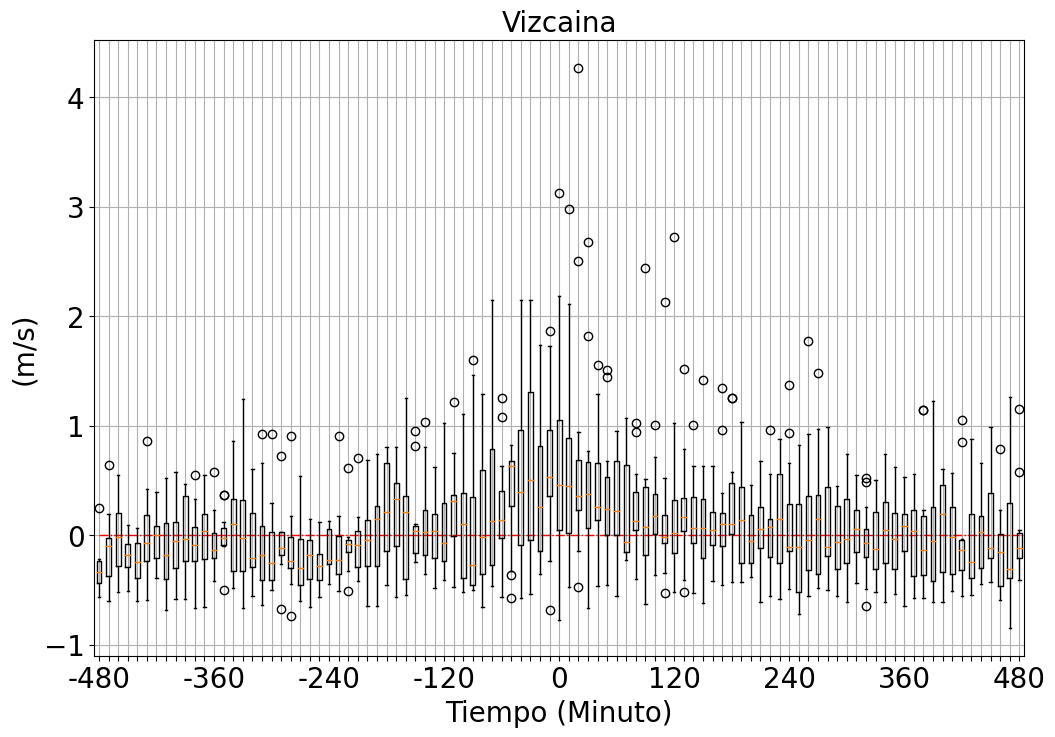

In [116]:
plot_caja_bigote(
    df=dfCrossVientos,
    columna_x="FECHA_POS",
    columna_y="VEL_VIENTO_anomalia",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Tiempo (Minuto)",
    rotulo_y="(m/s)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_PREC_caja_bigote_vizcaina_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_ANOMALIAS,
    lista_xtick=label_x_values_prec,
    #plt.xlim=[-480,480]
    #ylim=[-8, 8]
)

KeyError: ignored

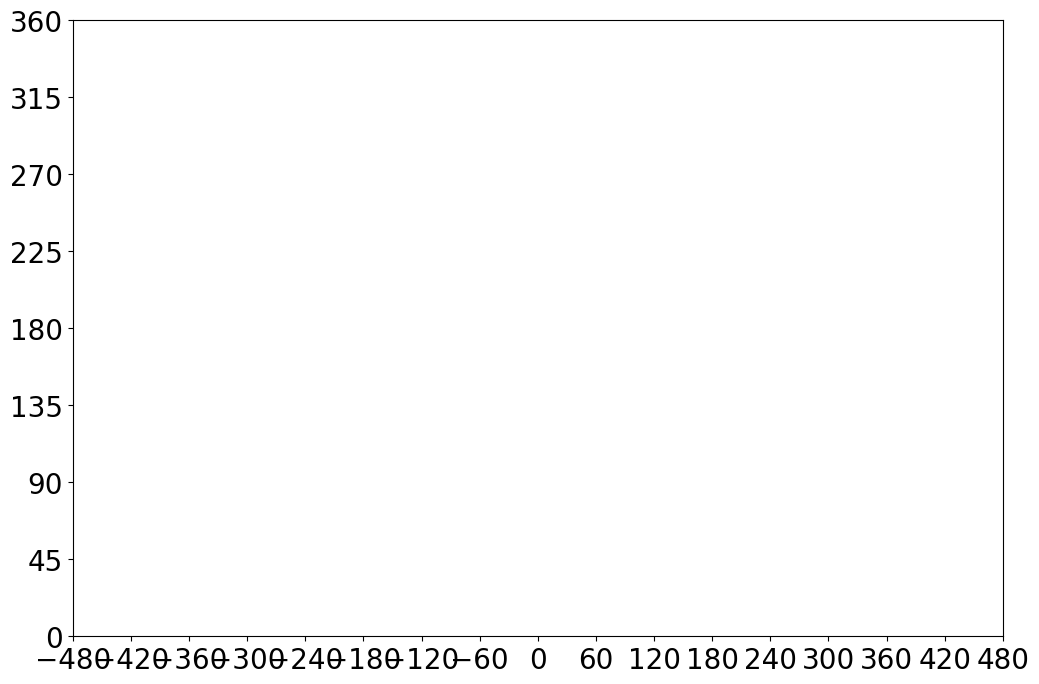

In [118]:
def plot_10m_interval_v2(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency])
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

def plot_dir_viento_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.yticks(range(0, 361, 45))
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'DIR_VIENTO' : {'title' : 'Análisis de la dirección del viento de eventos convectivos', 'name2save' : f'analisis_dir_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Dirección (°)'},
              'VEL_VIENTO' : {'title' : 'Análisis de la rapidez del viento de eventos convectivos', 'name2save' : f'analisis_vel_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Rapidez (m/s)'},
              'VEL_VIENTO_2' : {'title' : 'Análisis de la rapidez del viento de eventos convectivos considerando variabilidad', 'name2save' : f'analisis_vel_viento_std_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Rapidez (m/s)'},
             }

key = 'DIR_VIENTO'
plot_dir_viento_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit = [0, 360], has_std=False)

key = 'VEL_VIENTO'
plot_10m_interval_v2(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, has_std=False)

key = 'VEL_VIENTO_2'
plot_10m_interval_v2(dfCrossVientosGroup, 'VEL_VIENTO', dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, has_std=True)

## Anáisis de Percentiles

In [ ]:
dfCrossVientos

In [ ]:
def plot_percentil_interval(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  plt.plot(df['FECHA_POS'], df[0.5], label = f"Percentil {0.5}")
  ## Gráfica del promedio 
  #plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], linestyle = '--')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  
  # plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Vizcaína", fontsize= 20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


In [ ]:
list_percentil = [.10, .20,.25, .50, .75, .80, .90]
dfPercentilViento = dfCrossVientos.groupby("FECHA_POS")['VELVIENTO'].quantile(list_percentil).reset_index()
dfAggViento = dfCrossVientos.groupby("FECHA_POS").agg({"VELVIENTO" : ["mean", "std"]})

dfPercentilViento = dfPercentilViento.pivot(index='FECHA_POS', columns='level_1')['VELVIENTO'].reset_index()
dfPercentilViento = dfPercentilViento.join(dfAggViento, "FECHA_POS")

dict_names = {'title' : 'Análisis de rapidez del viento', 
              'name2save' : f'analisis_rapidez_viento_percentil_{NOMBRE_ESTACION}_{int_minutes}m.png', 
              'ylabel' : 'Rapidez (m/s)'
              }

plot_percentil_interval(dfPercentilViento, [.25, .75], 'VELVIENTO', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

# Análisis de viento por hora

In [ ]:
dfCrossVientosHora = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')

dfCrossVientosHora
# dfCrossVientosHoraGroup = dfCrossVientosHora.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()

dfCrossVientosHora['DIR_VIENTO'] = dfCrossVientosHora.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosHora['DIR_VIENTO'] = (dfCrossVientosHora['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosHora['VEL_VIENTO'] = dfCrossVientosHora.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosHora

In [ ]:
def plot_windrose(df, title, path_to_save):
  ax = WindroseAxes.from_ax()

  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
  plt.title(title)
  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
  plt.show()

In [ ]:
posHoras = set(list(dfCrossVientosHora['FECHA_POS']))
posHoras

In [ ]:
for hora in posHoras:
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'Rosa de viento en eventos convectivos h = {int(hora)} - {NOMBRE_ESTACION.capitalize()}'
  path_to_save = f'windrose_eventos_convectivos_hora_{int(hora)}_{NOMBRE_ESTACION.lower()}.png'
    
  plot_windrose(dft, title, path_to_save)

In [ ]:
def plot_windrose_2(df, title, ax):
  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'], fontsize= 20)
  ax.set_title(title)


fig, axs = plt.subplots(3, 3,figsize=(15,15),  subplot_kw=dict(projection="windrose"))
horas = list(posHoras)
horas.sort()

for ax, hora in zip(axs.reshape(9), horas):
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'h = {int(hora)}'
  plot_windrose_2(dft, title, ax)

path_to_save = f'subplot_vientos_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
plt.show()

# Gráficos multivariables en único Plot

In [ ]:
dfAnomalia

In [ ]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('HUM_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossPrecGroup['FECHA_POS']/60.0, dfCrossPrecGroup[('PREC', 'mean')], c = 'black')
ax3.set_ylim(0, 5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Humedad (%)")
ax3.set_ylabel("Precipitación (mm)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_hum_vs_prec_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )

In [ ]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('PRESION_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossVientosGroup['FECHA_POS']/60.0, dfCrossVientosGroup['VEL_VIENTO'], c = 'black')
# ax3.set_ylim(0, 0.5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Presión (hPa)")
ax3.set_ylabel("Velocidad del viento (m/s)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_pres_vs_velviento_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )